In [855]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

### Load the noisy image

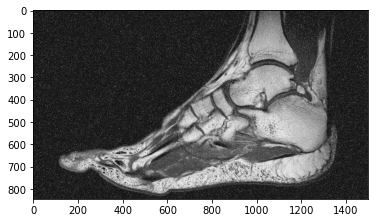

In [856]:
noisy_img = cv2.imread('noisy_img.png', 0)
plt.imshow(noisy_img, cmap='gray', vmin=noisy_img.min(), vmax=noisy_img.max())

In [857]:
noisy_img.shape

(844, 1500)

### Detect noise distribution type by cropping a proper part of the image

In [858]:
proper_pt = noisy_img[100:800, 0:105]

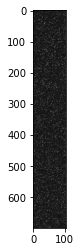

In [859]:
plt.imshow(proper_pt, cmap='gray', vmin=proper_pt.min(), vmax=proper_pt.max())

#### Display the histogram of the intensities.

(array([0.01907483, 0.01917007, 0.01957823, 0.01820408, 0.01829932,
        0.01911565, 0.01870748, 0.01889796, 0.01902041, 0.0197415 ,
        0.01859864, 0.01851701, 0.01922449, 0.01911565, 0.01922449,
        0.01896599, 0.01910204, 0.01865306, 0.01872109, 0.01915646,
        0.01884354, 0.01851701, 0.01994558, 0.01961905, 0.01889796,
        0.01847619, 0.01855782, 0.01896599, 0.01904762, 0.01971429,
        0.01866667, 0.01863946, 0.01794558, 0.01936054, 0.01956463,
        0.01888435, 0.0190068 , 0.01878912, 0.01953741, 0.01942857,
        0.01858503, 0.01948299, 0.01896599, 0.01877551, 0.01907483,
        0.02043537, 0.01972789, 0.01921088, 0.01880272, 0.01957823,
        0.01840816, 0.00379592, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

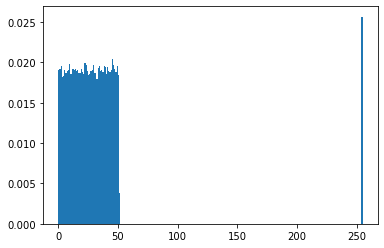

In [860]:
plt.hist(proper_pt.ravel(), density = True, bins=[i for i in range(proper_pt.min(), proper_pt.max() + 1)])

The noise distribution follows a uniform pattern

### Implement Alpha-trimmed mean filter

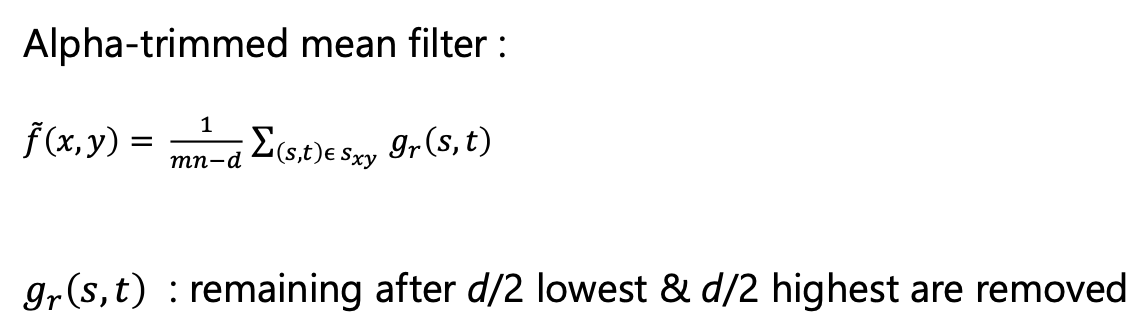

`5*5` kernel --> `r = 2`

`d = 10`

### Apply Alpha-trimmed mean filter on the image

- **Purpose**: To apply an Alpha-Trimmed Mean Filter on the input image. This filter is particularly useful for removing salt-and-pepper noise.

- **Functionality**: 
  - The function takes the input image, kernel size, and the 'd' parameter as arguments.
  - It pads the image using symmetric padding.
  - The function then applies the alpha-trimmed mean filtering technique by taking the neighborhood pixels, sorting them, and then removing 'd' smallest and 'd' largest pixel values.
  - The average of the remaining pixels is then calculated and set as the new pixel value.

- **Output**: 
  - Returns a filtered image where noise is reduced based on the alpha-trimmed mean technique.

In [861]:
def alpha_trimmed_mean_filter(img, kernel_size, d):
    r = kernel_size // 2
    # pad the image using mirror padding
    padded_image = np.pad(img, r, mode='symmetric')
    n, m = img.shape
    filtered_img = np.zeros(img.shape)
    # loop through all pixels
    for i in range(n):
        for j in range(m):
            # neighbors = []
            neighbors = list(padded_image[i-r:i+r+1, j-r:j+r+1].reshape(-1))
            neighbors.sort()
            neighbors_pruned = neighbors[r:-r]
            filtered_img[i, j] = (1/(m*n - d)) * sum(neighbors_pruned)
    return filtered_img

In [862]:
kernel_size, d = 5, 10
filtered_img = alpha_trimmed_mean_filter(noisy_img, kernel_size, d)

##### Display results

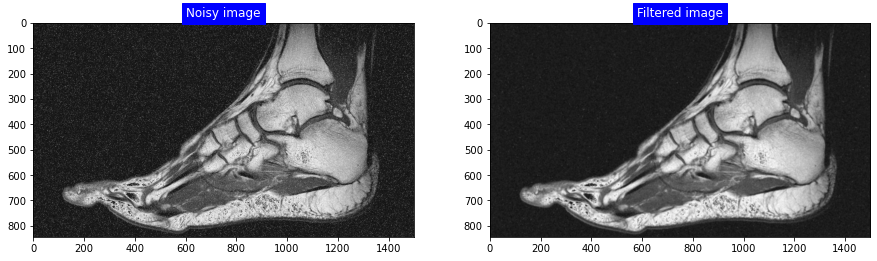

In [863]:
# Plot
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(1, 2)

# original image
ax1 = fig.add_subplot(gs[0, 0])
# ax1.imshow(chest_img, cmap='gray')
ax1.set_title('Noisy image', color='white', backgroundcolor='blue')
plt.imshow(noisy_img, cmap='gray', vmin=noisy_img.min(), vmax=noisy_img.max())

# filtered image
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Filtered image', color='white', backgroundcolor='blue')
plt.imshow(filtered_img, cmap='gray', vmin=filtered_img.min(), vmax=filtered_img.max())

### Inverse Filtering for image restoration
- **Objective**: To recover the original image that has been degraded and corrupted with Gaussian noise.
- **Method**: Utilize Inverse Filtering to reverse the effects of the degradation and Gaussian noise.
- **Expected Outcome**: A restored image that closely approximates the original, uncorrupted image.

##### Load the degraded image

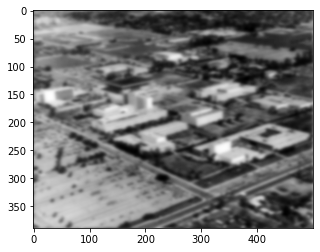

In [864]:
noisy_img = cv2.imread('degraded_img.png', 0)
plt.imshow(noisy_img, cmap='gray', vmin=noisy_img.min(), vmax=noisy_img.max())

##### Define fourier transform function

In [865]:
def fourier_transform(img):
    _fft = np.fft.fft2(img)
    # shift zero-frequency component to the center  
    fourier_image = np.fft.fftshift(_fft)
    return fourier_image

##### Define inverse fourier transform function

In [866]:
def inverse_fourier_trans(fourier_im):
    centered_img = np.fft.ifftshift(fourier_im)
    inverse_fourier = np.fft.ifft2(centered_img)
    return inverse_fourier

##### Define a function for calculating distance

In [867]:
def calc_distance(u, v, shape):
    P, Q = shape[0], shape[1]
    return math.sqrt(math.pow((u - P//2), 2) + math.pow((v - Q//2), 2))

##### Define a function to apply high-pass and low-pass butterworth filters 

In [868]:
def apply_filters(original_image, filter_type, filter_params, n=None):
    shape = original_image.shape
    filter = np.zeros(shape, dtype=np.float32)
    complement = np.ones(shape)

    if 'butterworth' in filter_type:
        for i in range(shape[0]):
            for j in range(shape[1]):
                filter[i, j] = 1/(1 + math.pow((calc_distance(i, j, shape)/filter_params), 2*n))

    # high-pass or low-pass
    if 'LP' in filter_type:
        return filter
    else:
        return complement - filter

In [869]:
fourier_img = fourier_transform(noisy_img)

In [870]:
LP_butterworth = apply_filters(noisy_img, 'LP_butterworth', 75, n=10)*fourier_img

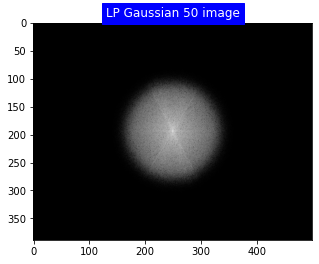

In [871]:
def log_abs(img):
    magnitude = np.abs(img)
    log_magnitude = np.log(magnitude + 1)
    return log_magnitude

# Plot
fig = plt.figure(figsize=(5, 10))
gs = fig.add_gridspec(1, 1)

# LP gaussian
ax2 = fig.add_subplot(gs[0, 0])
ax2.imshow(log_abs(LP_butterworth), cmap='gray')
ax2.set_title('LP Gaussian 50 image', color='white', backgroundcolor='blue')

plt.show()

In [872]:
LP_butterworth_image = np.abs(inverse_fourier_trans(LP_butterworth))

As part of the restoration process, we first define the necessary functions for frequency-domain operations. We then apply a 10th-order Butterworth filter with a cutoff frequency of 75 to reduce the noise in the image. The outcome is as displayed below.

Text(0.5, 1.0, 'LP butterworth image')

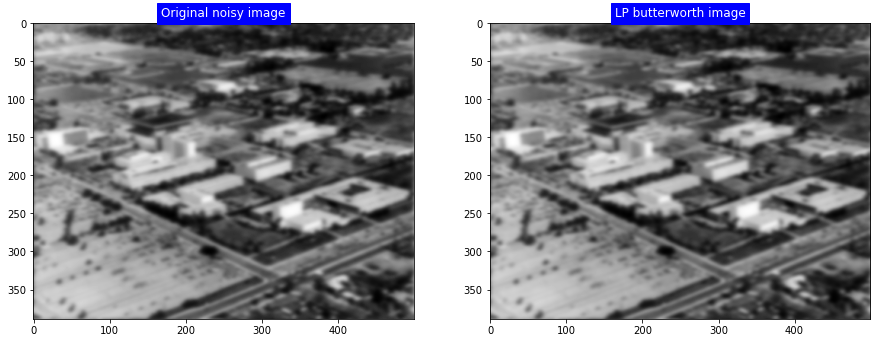

In [873]:
# Plot
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 2)

# Original noisy image
ax2 = fig.add_subplot(gs[0, 0])
ax2.imshow(noisy_img, cmap='gray')
ax2.set_title('Original noisy image', color='white', backgroundcolor='blue')

# LP gaussian
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(LP_butterworth_image, cmap='gray')
ax2.set_title('LP butterworth image', color='white', backgroundcolor='blue')

##### Next, we define the degradation function and divide it by the Fourier transform.

![Alt text](image.png)

Define degradation function

In [874]:
def degradation_func(x, y, M, N):
    return math.e**((-0.0025)*(((x-M/2)**2 + (y-N/2)**2)**(5/6)))

In [875]:
restored_f = np.zeros(fourier_img.shape)

In [876]:
for i in range(0, LP_butterworth.shape[0]):
    for j in range(0, LP_butterworth.shape[1]):
        restored_f[i, j] = LP_butterworth[i, j]/degradation_func(i, j, LP_butterworth.shape[0], LP_butterworth.shape[1])

/var/folders/6r/w62sfhrd3ngblgfy4mbzgg700000gn/T/ipykernel_2644/3674046700.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  restored_f[i, j] = LP_butterworth[i, j]/degradation_func(i, j, LP_butterworth.shape[0], LP_butterworth.shape[1])


In [877]:
LP_butterworth_image = np.abs(inverse_fourier_trans(restored_f))

##### Display the final restored image

Text(0.5, 1.0, 'Restored image')

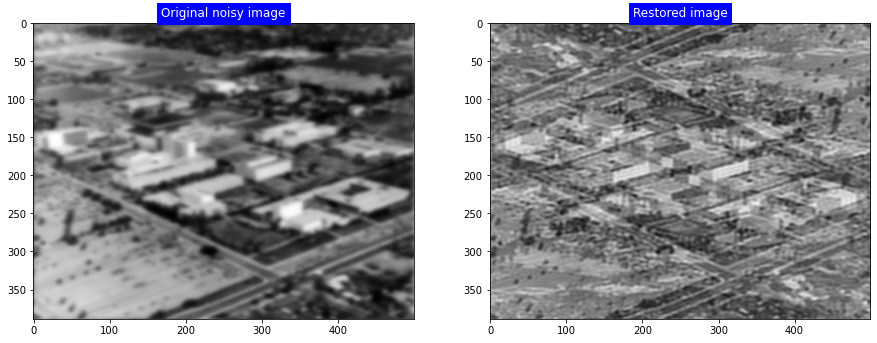

In [878]:
# Plot
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 2)

# Original noisy image
ax2 = fig.add_subplot(gs[0, 0])
ax2.imshow(noisy_img, cmap='gray')
ax2.set_title('Original noisy image', color='white', backgroundcolor='blue')

# LP gaussian
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(LP_butterworth_image, cmap='gray')
ax2.set_title('Restored image', color='white', backgroundcolor='blue')